En este código se encuentra el paso a paso de nuestro proyecto final del máster, en el que se extraen datos de distintas API's para lograr compilar datos y lograr armar un modelo para predecir la probabilidad de que USA entre en recesión económica

In [1]:
# !python -m pip install scikit-learn

In [2]:
# !python -m pip install xgboost

__DESCRIPCION DE VARIABLES__

- __VIX:__
Índice de volatilidad, tiende a aumentar durante períodos de turbulencia financiera o incertidumbre del mercado.

Relación con USREC: Durante períodos de recesión económica, la volatilidad en los mercados financieros tiende a aumentar, ya que los inversores se vuelven más preocupados y los precios de las acciones pueden experimentar movimientos abruptos. Por lo tanto, se espera que el VIX tenga una relación inversa con la variable objetivo USREC: cuando el VIX aumenta, es más probable que estemos en una recesión económica.

- __DESEMPLEO:__
Tasa de desempleo, es una medida que indica el porcentaje de la fuerza laboral total que está desempleada pero buscando activamente empleo. 

Relación con USREC: Durante las recesiones económicas, la tasa de desempleo tiende a aumentar a medida que las empresas reducen la contratación y los trabajadores pierden sus empleos. Por lo tanto, se espera que la tasa de desempleo tenga una relación positiva con la variable objetivo USREC: cuando la tasa de desempleo aumenta, es más probable que estemos en una recesión económica.

- __INTEREST RATE:__
Tasa de fondos federales, es la tasa de interés a corto plazo a la cual los bancos prestan dinero entre sí de la Reserva Federal. Es una de las herramientas clave utilizadas por la Reserva Federal para controlar la política monetaria y afecta a las tasas de interés en toda la economía.

Relación con USREC: Durante las recesiones económicas, la Reserva Federal a menudo reduce las tasas de interés para estimular la actividad económica y fomentar la inversión y el gasto. Por lo tanto, se espera que las tasas de interés tengan una relación negativa con la variable objetivo USREC: cuando las tasas de interés disminuyen, es más probable que estemos en una recesión económica.

- __YIELD CURVE:__
Tasa de rendimiento de los bonos del Tesoro a 10 años menos la tasa de rendimiento de los bonos del Tesoro a 2 años, también conocida como "spread" entre los bonos del Tesoro a 10 y 2 años. Este indicador se utiliza a menudo como una medida de las expectativas del mercado sobre la dirección futura de la economía.

Relación con USREC: Un spread de rendimiento estrecho o negativo entre los bonos del Tesoro a largo y corto plazo a menudo se interpreta como una señal de debilidad económica o una posible recesión. Por lo tanto, se espera que el spread entre los bonos del Tesoro tenga una relación positiva con la variable objetivo USREC: cuando el spread se estrecha o se vuelve negativo, es más probable que estemos en una recesión económica.

- __M2__:
Money Stock es una medida de la cantidad total de dinero en circulación en la economía que incluye el efectivo, los depósitos a la vista y a plazo en bancos comerciales, y otros activos líquidos. Es una medida amplia de la oferta monetaria y es monitoreada de cerca por los bancos centrales y los economistas como un indicador de la liquidez y la disponibilidad de crédito en la economía.

Relación con USREC: Durante las recesiones económicas, la cantidad de dinero en circulación y la disponibilidad de crédito pueden disminuir a medida que las instituciones financieras se vuelven más reacias a prestar y los consumidores reducen su gasto. Por lo tanto, se espera que la M2 Money Stock tenga una relación negativa con la variable objetivo USREC: cuando la M2 Money Stock disminuye, es más probable que estemos en una recesión económica.

- __PER CAPITA CONSUMPTION:__
Per Capita Consumption es una medida del gasto total de consumo en la economía dividido por la población total, lo que proporciona una estimación del gasto promedio por persona. Es una medida clave del nivel de vida y el comportamiento de gasto de los consumidores en una economía.


Relación con USREC: Durante las recesiones económicas, el gasto de consumo tiende a disminuir a medida que los consumidores reducen su gasto en bienes y servicios discrecionales y tienden a ahorrar más en respuesta a la incertidumbre económica y laboral. Por lo tanto, se espera que el Per Capita Consumption tenga una relación negativa con la variable objetivo USREC: cuando el gasto de consumo per cápita disminuye, es más probable que estemos en una recesión económica.

- __CONSUMER PRICE INDEX:__
Consumer Price Index (CPI) es una medida del nivel promedio de precios de bienes y servicios de consumo en la economía. Se utiliza para medir la inflación y es un indicador importante de la estabilidad de precios y el poder adquisitivo del consumidor.

Relación con USREC: Durante las recesiones económicas, la inflación tiende a disminuir a medida que la demanda de bienes y servicios se debilita y la capacidad excedente en la economía aumenta la presión a la baja sobre los precios. Por lo tanto, se espera que el Consumer Price Index tenga una relación negativa con la variable objetivo USREC: cuando la inflación disminuye, es más probable que estemos en una recesión económica.

- __S&P 500:__
índice bursátil que sigue el rendimiento de 500 de las empresas más grandes y ampliamente negociadas en los Estados Unidos. Estas empresas representan una amplia gama de sectores de la economía y son seleccionadas por su tamaño de mercado, liquidez y representatividad de la economía estadounidense. El S&P 500 es considerado uno de los principales indicadores del desempeño del mercado de valores de los Estados Unidos y es ampliamente utilizado como referencia por inversores y analistas.

Relación con USREC: La relación entre el S&P 500 y la variable objetivo USREC (indicador de recesión) puede ser más compleja que las otras variables mencionadas anteriormente. En general, durante las recesiones económicas, el S&P 500 tiende a experimentar caídas significativas a medida que los inversores se vuelven más cautelosos y los beneficios corporativos se ven afectados por la desaceleración económica. Sin embargo, también es importante tener en cuenta que los movimientos del mercado de valores pueden anticipar cambios en la economía real, y las políticas monetarias y fiscales pueden influir en la dirección del mercado. Por lo tanto, aunque una caída significativa en el S&P 500 puede indicar preocupaciones sobre una recesión, no siempre es un indicador directo de la economía real y puede haber otros factores en juego.

In [3]:
import requests
import pandas as pd
from fred_key import fred_key
import openpyxl
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix
import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")




In [4]:
today_date = datetime.today().strftime('%Y-%m-%d')

In [5]:
api_key = fred_key

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

# Define indicators and their corresponding FRED series IDs
indicators = {
   'VIX': 'VIXCLS', #Daily #1976-06-01
   'Unemployment': 'UNRATE', #Montlhy #1948-01-01
#    'S&P500': 'SP500', #Daily #1920
   'Interest_Rates': 'FEDFUNDS', #Montlhy #1954-07-01
   'YIC':'T10Y2Y', #Daily #1976-06-01 
   'M2 MONEY STOCK': 'M2SL',
   'PER CAPITA CONSUMPTION': 'PCEPILFE',
   'CONSUMER PRICE INDEX': 'CPIAUCNS',
    'USREC_1' : 'USREC', #Monthly #1854-12-01,
}

# Assign common parameters
start_date = '1990-01-01'

end_date = today_date
#
file_type = 'json'
ts_frequency = 'm'

# Fetch data for each indicator
data_frames = {}
for indicator, series_id in indicators.items():
    obs_params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': file_type,
        'observation_start': start_date,
        'observation_end': end_date,
        'frequency': ts_frequency,
        #'units': ts_units #percentaje value from last year
    }

    # Make request to FRED API
    response = requests.get(base_url + 'series/observations', params=obs_params)

    # Create DataFrame for each indicator
    if response.status_code == 200:
        res_data = response.json()
        obs_data = pd.DataFrame(res_data['observations'])
        obs_data['date'] = pd.to_datetime(obs_data['date'])
        obs_data.set_index('date', inplace=True)
        obs_data['value'] = obs_data['value']
        data_frames[indicator] = obs_data
    else:
        print(f'Failed to retrieve data for {indicator}. Status code:', response.status_code)

Para descargar los datos desde la API de la FRED:

In [6]:
# Display the modified DataFrames for each indicator
for indicator, df in data_frames.items():
    # Create a modified DataFrame by dropping specified columns
    modified_df = df.drop(['realtime_start', 'realtime_end'], axis=1)
    
    # Store the modified DataFrame in the dictionary
    data_frames[indicator] = modified_df


# Concatenar los DataFrames
combined_df = pd.concat(data_frames.values(), axis=1, keys=data_frames.keys())

# Eliminar el nivel de nombre 'value' de las columnas
combined_df.columns = combined_df.columns.droplevel(1)

combined_df['USREC'] = combined_df['USREC_1']

combined_df = combined_df.drop('USREC_1', axis = 1)

# Reset Index
combined_df.reset_index(inplace=True)


combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.4,0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.0,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.7,0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.9,0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.2,0
...,...,...,...,...,...,...,...,...,...
409,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.201,310.326,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20842.1,121.606,312.332,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20870.2,121.909,313.548,0
412,2024-05-01,13.06,4.0,5.33,-0.37,20963.4,NaN,314.069,0


Eliminar el mes actual, ya que no se cuenta con esa información

In [7]:
combined_df = combined_df[:-1]

combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.4,0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.0,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.7,0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.9,0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.2,0
...,...,...,...,...,...,...,...,...,...
408,2024-01-01,13.39,3.7,5.33,-0.26,20754.4,120.878,308.417,0
409,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.201,310.326,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20842.1,121.606,312.332,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20870.2,121.909,313.548,0


Para la limpieza de datos, se observa que los nulos son solo 2:  M2 money stock y Per Capita consumption

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    413 non-null    datetime64[ns]
 1   VIX                     413 non-null    object        
 2   Unemployment            413 non-null    object        
 3   Interest_Rates          413 non-null    object        
 4   YIC                     413 non-null    object        
 5   M2 MONEY STOCK          413 non-null    object        
 6   PER CAPITA CONSUMPTION  412 non-null    object        
 7   CONSUMER PRICE INDEX    413 non-null    object        
 8   USREC                   413 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 29.2+ KB


In [9]:

# Seleccionar las columnas que deseas convertir a float64
columnas = combined_df.columns[1:]

# Iterar sobre cada columna seleccionada y convertir los valores numéricos a tipo float64
for col in columnas:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df



,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.400,0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.000,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.700,0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.900,0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.200,0
...,...,...,...,...,...,...,...,...,...
408,2024-01-01,13.39,3.7,5.33,-0.26,20754.4,120.878,308.417,0
409,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.201,310.326,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20842.1,121.606,312.332,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20870.2,121.909,313.548,0


In [10]:
combined_df.tail(8)

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
405,2023-10-01,18.89,3.8,5.33,-0.27,20691.7,120.015,307.671,0
406,2023-11-01,14.02,3.7,5.33,-0.38,20705.1,120.122,307.051,0
407,2023-12-01,12.72,3.7,5.33,-0.44,20754.0,120.305,306.746,0
408,2024-01-01,13.39,3.7,5.33,-0.26,20754.4,120.878,308.417,0
409,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.201,310.326,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20842.1,121.606,312.332,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20870.2,121.909,313.548,0
412,2024-05-01,13.06,4.0,5.33,-0.37,20963.4,NaN,314.069,0


In [11]:
combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.400,0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.000,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.700,0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.900,0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.200,0
...,...,...,...,...,...,...,...,...,...
408,2024-01-01,13.39,3.7,5.33,-0.26,20754.4,120.878,308.417,0
409,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.201,310.326,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20842.1,121.606,312.332,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20870.2,121.909,313.548,0


In [12]:


# Calcular la división promedio entre cada celda y su celda anterior
factor_M2 = (combined_df['M2 MONEY STOCK'] / combined_df['M2 MONEY STOCK'].shift(1)).mean(skipna=True)
factor_PCP = (combined_df['PER CAPITA CONSUMPTION'] / combined_df['PER CAPITA CONSUMPTION'].shift(1)).mean(skipna=True)
factor_CPI = (combined_df['CONSUMER PRICE INDEX'] / combined_df['CONSUMER PRICE INDEX'].shift(1)).mean(skipna=True)






In [13]:
print(f'M2 factor: {factor_M2}')
print(f'PCP factor: {factor_PCP}')
print(f'PCP factor: {factor_CPI}')


M2 factor: 1.0046131487215864
PCP factor: 1.001760660443669
PCP factor: 1.0021981942411324


In [14]:
combined_df['M2 MONEY STOCK'] = combined_df['M2 MONEY STOCK'].fillna(method='ffill') * factor_M2
combined_df['PER CAPITA CONSUMPTION'] = combined_df['PER CAPITA CONSUMPTION'].fillna(method='ffill') * factor_PCP
combined_df['CONSUMER PRICE INDEX'] = combined_df['CONSUMER PRICE INDEX'].fillna(method='ffill') * factor_CPI


In [15]:
combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3181.408919,59.285198,127.680050,0
1,1990-02-01,23.26,5.3,8.24,0.10,3193.866122,59.572703,128.281369,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3204.816406,59.859207,128.982908,0
3,1990-04-01,21.40,5.4,8.26,0.06,3216.369457,60.037520,129.183347,0
4,1990-05-01,18.10,5.4,8.18,0.12,3215.364844,60.220842,129.484007,0
...,...,...,...,...,...,...,...,...,...
408,2024-01-01,13.39,3.7,5.33,-0.26,20850.143134,121.090825,309.094960,0
409,2024-02-01,13.98,3.9,5.33,-0.34,20844.316378,121.414394,311.008157,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20938.247707,121.820107,313.018566,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20966.477336,122.123640,314.237239,0


In [16]:
combined_df.to_excel('dataframe.xlsx', index = False)

In [17]:

# Convertir la columna de fechas a una representación numérica antes de la división de datos
combined_df['date'] = combined_df['date'].astype('int64')

scaler = MinMaxScaler()

# Normalizar el DataFrame excepto la columna 'date'
columns_to_normalize = combined_df.columns.difference(['date','USREC'])  # Excluir la columna 'date'
combined_df[columns_to_normalize] = scaler.fit_transform(combined_df[columns_to_normalize])

# Suponiendo que df contiene tu DataFrame original con los datos
X = combined_df.drop('USREC', axis=1)
y = combined_df['USREC']

combined_df


,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,631152000000000000,0.251618,0.175439,0.992718,0.279255,0.000000,0.000000,0.000000,0
1,633830400000000000,0.249905,0.166667,0.993932,0.273936,0.000668,0.004575,0.003214,0
2,636249600000000000,0.188999,0.157895,0.998786,0.236702,0.001256,0.009135,0.006964,0
3,638928000000000000,0.214503,0.175439,0.996359,0.263298,0.001875,0.011972,0.008036,0
4,641520000000000000,0.151694,0.175439,0.986650,0.279255,0.001822,0.014890,0.009643,0
...,...,...,...,...,...,...,...,...,...
408,1704067200000000000,0.062048,0.026316,0.640777,0.178191,0.947838,0.983564,0.969722,0
409,1706745600000000000,0.073278,0.043860,0.640777,0.156915,0.947525,0.988713,0.979948,0
410,1709251200000000000,0.069661,0.035088,0.640777,0.146277,0.952564,0.995170,0.990695,0
411,1711929600000000000,0.114389,0.043860,0.640777,0.159574,0.954078,1.000000,0.997209,0


<Figure size 1200x800 with 0 Axes>

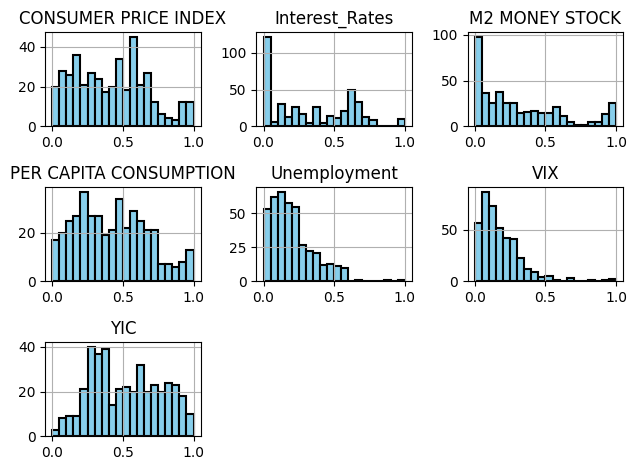

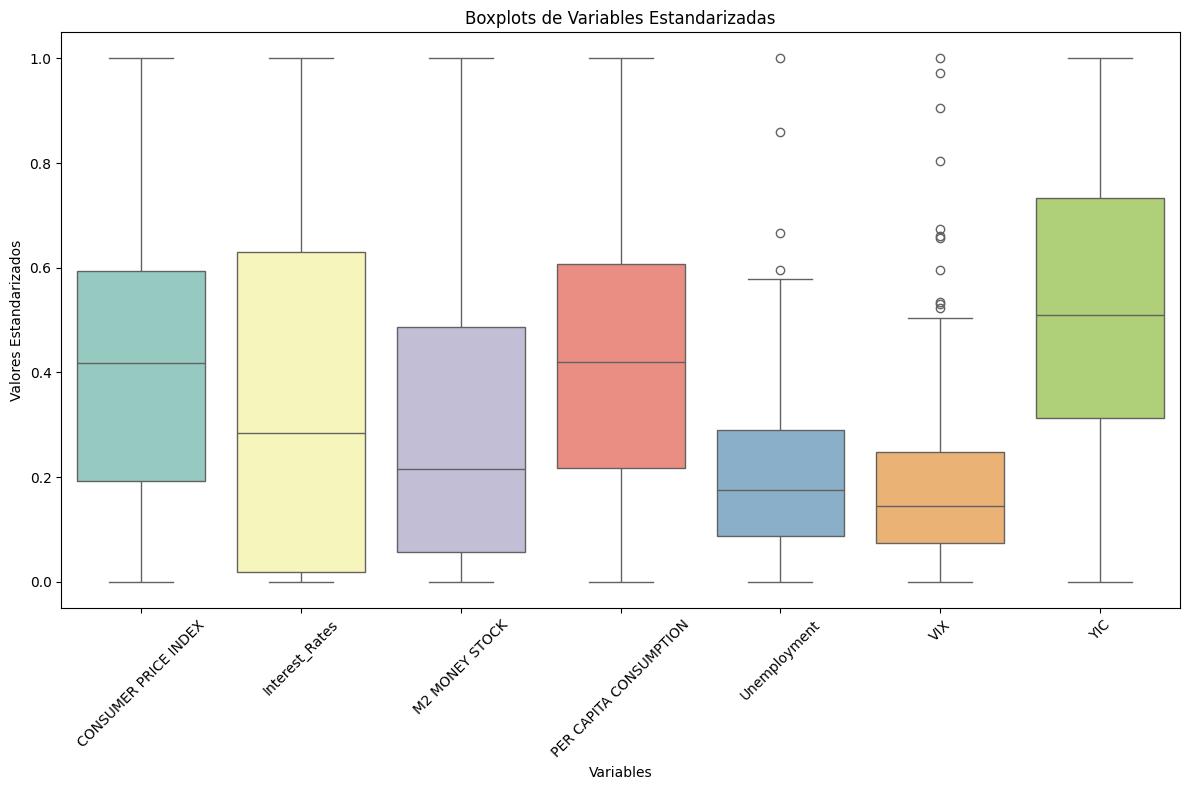

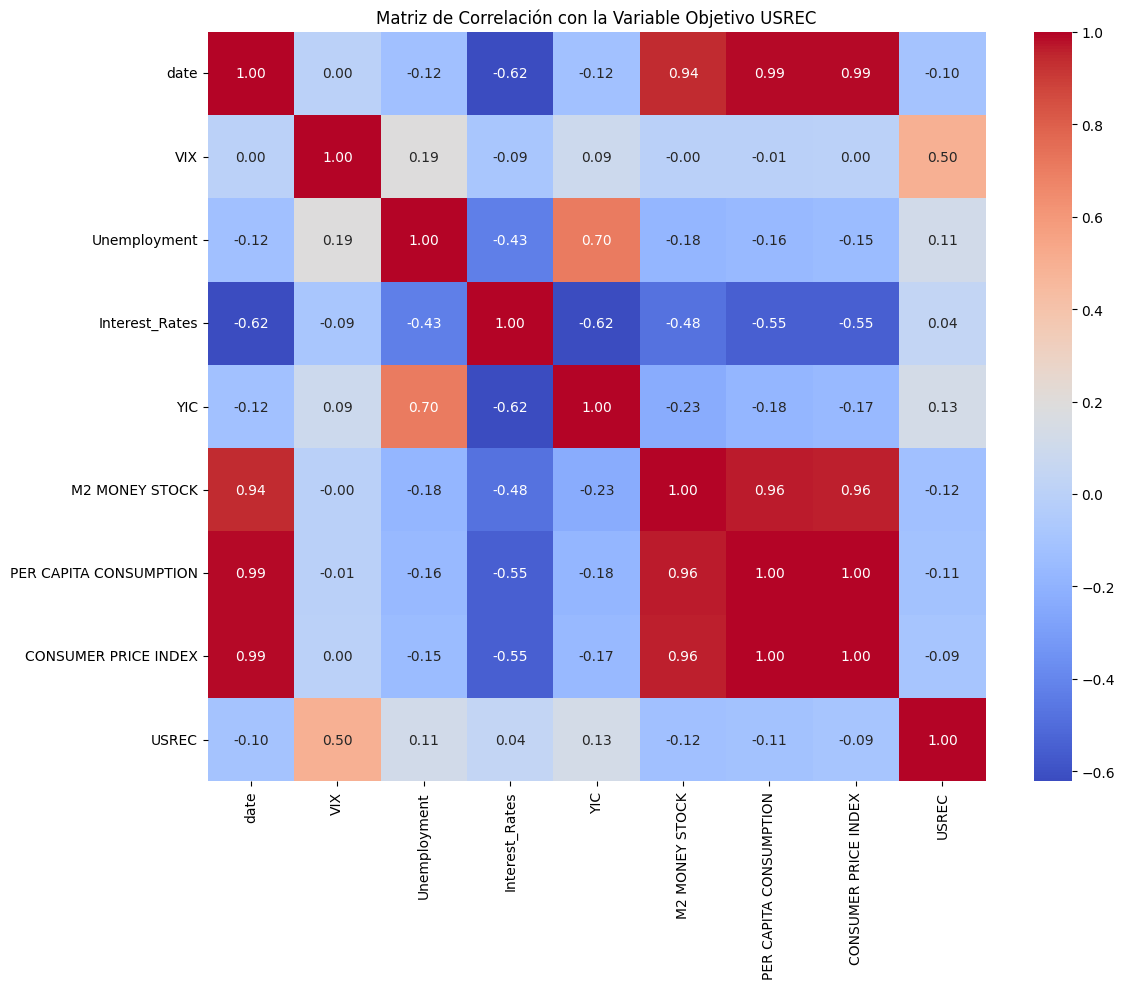

In [18]:

# Histogramas de las variables estandarizadas
plt.figure(figsize=(12, 8))
combined_df[columns_to_normalize].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.5)
plt.title('Histogramas de Variables Estandarizadas')
plt.xlabel('Valores Estandarizados')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplots de las variables estandarizadas
plt.figure(figsize=(12, 8))
sns.boxplot(data=combined_df[columns_to_normalize], palette='Set3')
plt.title('Boxplots de Variables Estandarizadas')
plt.xlabel('Variables')
plt.ylabel('Valores Estandarizados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Matriz de correlación con la variable objetivo 'USREC'
plt.figure(figsize=(12, 10))
correlation_matrix = combined_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación con la Variable Objetivo USREC')
plt.tight_layout()
plt.show()


In [19]:
def rf_model(X_train, y_train, X_test, y_test):

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Configurar el estimador
    rf_regressor = RandomForestRegressor(random_state=42)

    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_rf_regressor = grid_search.best_estimator_

    # Obtener las importancias de las características
    feature_importances = best_rf_regressor.feature_importances_

    # Obtener nombres de las características
    feature_names = X_train.columns

    # Transformar a un diccionario {'variable': 'importancia'}
    feature_importance_dict = {feature_names[i]: importance for i, importance in enumerate(feature_importances)}

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_rf_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    print("Error cuadrático medio Random Forest:", mse)
    
    return y_pred, mse, best_rf_regressor, feature_importance_dict



def xgboost_model(X_train, y_train, X_test, y_test):

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    }

    # Configurar el estimador
    xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_xgb_regressor = grid_search.best_estimator_

    # Obtener las importancias de las características
    feature_importances = best_xgb_regressor.feature_importances_

    # Obtener nombres de las características
    feature_names = X_train.columns

    # Transformar a un diccionario {'variable': 'importancia'}
    feature_importance_dict = {feature_names[i]: importance for i, importance in enumerate(feature_importances)}

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_xgb_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    print("Error cuadrático medio XGBoost:", mse)
    
    return y_pred, mse, best_xgb_regressor, feature_importance_dict



def mlr_model(X_train, y_train, X_test, y_test):

    # Definir los parámetros para la búsqueda de hiperparámetros para los diferentes modelos de regresión
    param_grid = [
        {
            'model': [LinearRegression()],
            'model__fit_intercept': [True, False],
        },
        {
            'model': [Ridge()],
            'model__alpha': [0.1, 0.5, 1.0],
            'model__fit_intercept': [True, False],

        },
        {
            'model': [Lasso()],
            'model__alpha': [0.1, 0.5, 1.0],
            'model__fit_intercept': [True, False],

        },
        {
            'model': [ElasticNet()],
            'model__alpha': [0.1, 0.5, 1.0],
            'model__l1_ratio': [0.1, 0.5, 0.9],
            'model__fit_intercept': [True, False],
        
        }
    ]

    # Configurar el GridSearchCV
    grid_search = GridSearchCV(estimator=Pipeline([('model', LinearRegression())]), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Realizar la búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_mlr_regressor = grid_search.best_estimator_

    # Obtener coeficientes de características si el mejor modelo es una regresión lineal
    if isinstance(best_mlr_regressor.named_steps['model'], LinearRegression):
        coefficients = best_mlr_regressor.named_steps['model'].coef_
        # Obtener nombres de las características
        feature_names = X_train.columns
        # Transformar a un diccionario {'variable': 'coeficiente'}
        coefficient_dict = {feature_names[i]: coefficients[i] for i in range(len(feature_names))}
    else:
        coefficients = None
        coefficient_dict = None

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_mlr_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)

    print("Error cuadrático medio Multiple Linear Regression:", mse)
    return y_pred, mse, best_mlr_regressor, coefficient_dict


In [20]:
combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,631152000000000000,0.251618,0.175439,0.992718,0.279255,0.000000,0.000000,0.000000,0
1,633830400000000000,0.249905,0.166667,0.993932,0.273936,0.000668,0.004575,0.003214,0
2,636249600000000000,0.188999,0.157895,0.998786,0.236702,0.001256,0.009135,0.006964,0
3,638928000000000000,0.214503,0.175439,0.996359,0.263298,0.001875,0.011972,0.008036,0
4,641520000000000000,0.151694,0.175439,0.986650,0.279255,0.001822,0.014890,0.009643,0
...,...,...,...,...,...,...,...,...,...
408,1704067200000000000,0.062048,0.026316,0.640777,0.178191,0.947838,0.983564,0.969722,0
409,1706745600000000000,0.073278,0.043860,0.640777,0.156915,0.947525,0.988713,0.979948,0
410,1709251200000000000,0.069661,0.035088,0.640777,0.146277,0.952564,0.995170,0.990695,0
411,1711929600000000000,0.114389,0.043860,0.640777,0.159574,0.954078,1.000000,0.997209,0


In [21]:
combined1, combined2 = train_test_split(combined_df, test_size=0.2, random_state=42)

X = combined1.drop(['USREC','date'], axis=1)
y = combined1['USREC']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print(f'train shape: {combined1.shape}')
print(f'test shape: {combined2.shape}')

train shape: (330, 9)
test shape: (83, 9)


In [23]:
rf_pred = rf_model(X_train,y_train,X_test,y_test)
xgboost_pred = xgboost_model(X_train,y_train,X_test,y_test)
mlr_pred = mlr_model(X_train,y_train,X_test,y_test)

Error cuadrático medio Random Forest: 0.02427205387205387
Error cuadrático medio XGBoost: 0.01596411578506096
Error cuadrático medio Multiple Linear Regression: 0.05792677796065204


Guardamos el mejor modelo para cada caso

In [24]:
best_rf_regressor = rf_pred[2]
best_xgboost_regressor = xgboost_pred[2]
best_mlr_regressor = mlr_pred[2]

In [25]:
variables_rendimiento_rf = rf_pred[3]
variables_rendimiento_xgb = xgboost_pred[3]
variables_rendimiento_mlr = mlr_pred[3]


In [49]:
variables_rendimiento_mlr

{'VIX': 0.9862408056380986,
 'Unemployment': -0.4401195310986126,
 'Interest_Rates': 0.13376421938330071,
 'YIC': 0.2735882457434673,
 'M2 MONEY STOCK': 0.24613711751561498,
 'PER CAPITA CONSUMPTION': -7.860410907945475,
 'CONSUMER PRICE INDEX': 7.417547157961639}

In [27]:
variables_rendimiento_rf

{'VIX': 0.41838944221721447,
 'Unemployment': 0.04068047708139939,
 'Interest_Rates': 0.14015219758231848,
 'YIC': 0.20210618544654088,
 'M2 MONEY STOCK': 0.07659827090836889,
 'PER CAPITA CONSUMPTION': 0.07137836780458091,
 'CONSUMER PRICE INDEX': 0.050695058959576975}

In [48]:
variables_rendimiento_xgb

{'VIX': 0.17138095,
 'Unemployment': 0.058003806,
 'Interest_Rates': 0.15826693,
 'YIC': 0.24405009,
 'M2 MONEY STOCK': 0.25793752,
 'PER CAPITA CONSUMPTION': 0.061523836,
 'CONSUMER PRICE INDEX': 0.04883679}

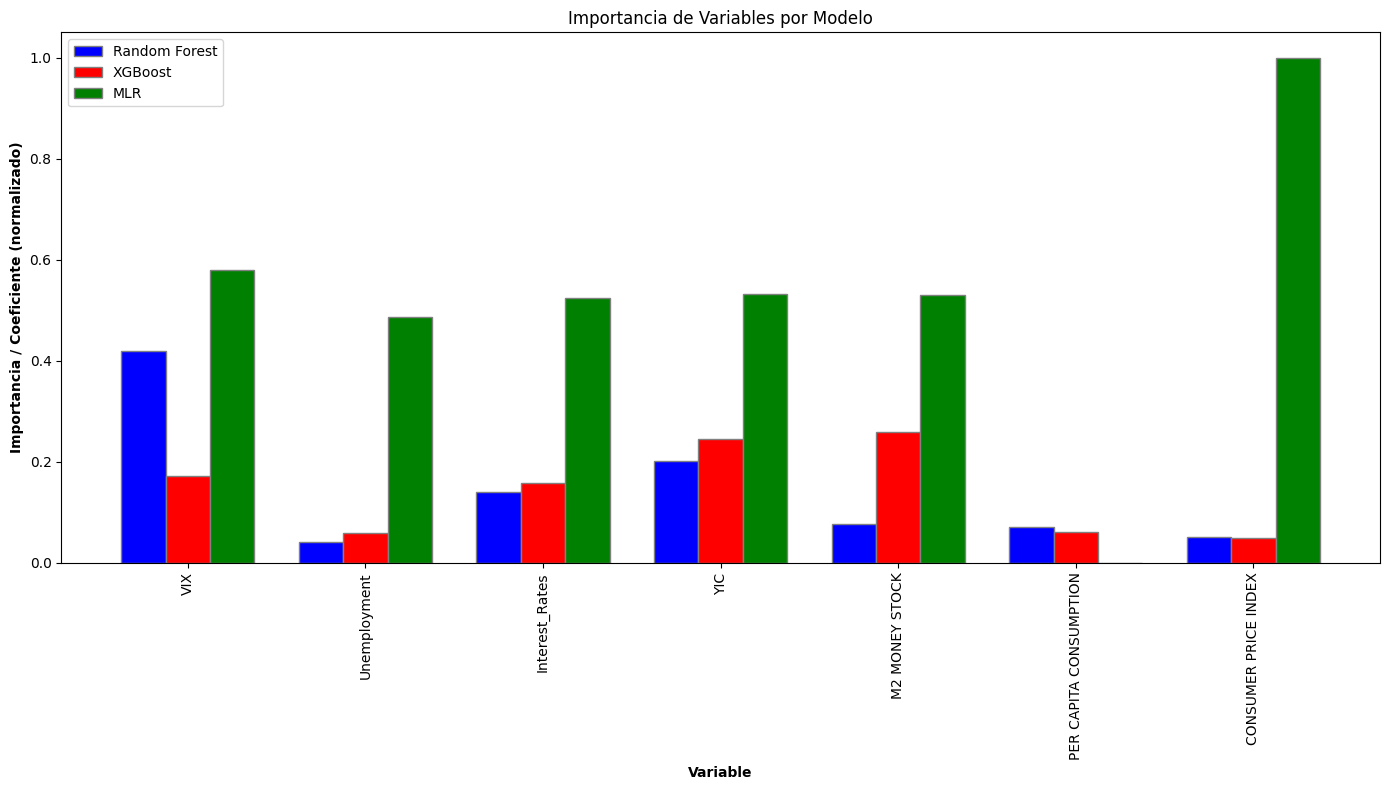

In [47]:

# Crear un DataFrame de pandas a partir de los diccionarios
df_rf = pd.DataFrame(list(variables_rendimiento_rf.items()), columns=['Variable', 'Importancia_RF'])
df_xgb = pd.DataFrame(list(variables_rendimiento_xgb.items()), columns=['Variable', 'Importancia_XGB'])
df_mlr = pd.DataFrame(list(variables_rendimiento_mlr.items()), columns=['Variable', 'Coeficiente_MLR'])

# Normalizar los coeficientes de MLR entre 0 y 1
scaler = MinMaxScaler()
df_mlr['Coeficiente_MLR'] = scaler.fit_transform(df_mlr[['Coeficiente_MLR']])

# Unir los DataFrames en uno solo
df = df_rf.merge(df_xgb, on='Variable').merge(df_mlr, on='Variable')

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Establecer el ancho de las barras
bar_width = 0.25

# Posiciones en el eje x
r1 = range(len(df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Crear las barras
ax.bar(r1, df['Importancia_RF'], color='b', width=bar_width, edgecolor='grey', label='Random Forest')
ax.bar(r2, df['Importancia_XGB'], color='r', width=bar_width, edgecolor='grey', label='XGBoost')
ax.bar(r3, df['Coeficiente_MLR'], color='g', width=bar_width, edgecolor='grey', label='MLR')

# Agregar etiquetas y título
ax.set_xlabel('Variable', fontweight='bold')
ax.set_ylabel('Importancia / Coeficiente (normalizado)', fontweight='bold')
ax.set_title('Importancia de Variables por Modelo')
ax.set_xticks([r + bar_width for r in range(len(df))])
ax.set_xticklabels(df['Variable'], rotation=90)

# Añadir la leyenda
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [29]:
# Guardar cada modelo en un fichero
joblib.dump(best_rf_regressor, 'best_rf_regressor.pkl')
joblib.dump(best_xgboost_regressor, 'best_xgboost_regressor.pkl')
joblib.dump(best_mlr_regressor, 'best_mlr_regressor.pkl')

['best_mlr_regressor.pkl']

Factores de penalización para ponderar las probabilidad final predicha por cada modelo

In [30]:
total_mse = rf_pred[1] + xgboost_pred[1] + mlr_pred[1]

factor_rf = rf_pred[1] / total_mse  
factor_xgboost = xgboost_pred[1] / total_mse  
factor_mlr = mlr_pred[1] / total_mse  

In [31]:
print(f'Factor random forest {factor_rf}')
print(f'Factor XG Boost {factor_xgboost}')
print(f'Factor Multiple Linear Regresion {factor_mlr}')

factor_mlr+factor_rf+factor_xgboost

Factor random forest 0.24726288748546893
Factor XG Boost 0.16262873286184368
Factor Multiple Linear Regresion 0.5901083796526875


1.0

GUARDO LOS FACTORES DE PENALIZACIÓN PARA USARLOS EN LA PREdICCIÓN

In [32]:
with open('factores.txt', 'w') as factores:
    factores.write(f'{factor_rf}\n')
    factores.write(f'{factor_mlr}\n')
    factores.write(f'{factor_xgboost}\n')
    factores.write(f'{total_mse}')

In [33]:
x_real = combined2.drop(['USREC','date'], axis = 1)
y_real, y_date = combined2['USREC'], combined2['date']

rf_test_pred = best_rf_regressor.predict(x_real)
xgboost_test_pred = best_xgboost_regressor.predict(x_real)
mlr_test_pred = best_mlr_regressor.predict(x_real)

In [34]:
combined2['date1'] = pd.to_datetime(combined2['date'], unit='ns')

predictions = pd.DataFrame()
predictions['Date'] = combined2['date1'].dt.strftime('%d-%m-%Y')
predictions['Original'] = combined2['USREC']
predictions['Random Forest'] = rf_test_pred
predictions['XG Boost'] = xgboost_test_pred
predictions['Multiple Linear Regression'] = mlr_test_pred

# predictions['Probabilidad ponderada'] = (((predictions['Random Forest']/factor_rf) + (predictions['XG Boost']/factor_xgboost) + (predictions['Multiple Linear Regression']/factor_mlr))*100* total_mse).round(2)
predictions['Probabilidad ponderada'] = (((predictions['Random Forest']/factor_rf) + (predictions['XG Boost']/factor_xgboost) + (predictions['Multiple Linear Regression']/factor_mlr))* total_mse).round(2)

column_to_normalize = 'Probabilidad ponderada'
min_value = predictions[column_to_normalize].min()
max_value = predictions[column_to_normalize].max()

predictions[column_to_normalize] = (predictions[column_to_normalize] - min_value) / (max_value - min_value)


# Aplicar el escalado Min-Max a la columna 'probabilidad'
predictions['Probabilidad ponderada'] = predictions['Probabilidad ponderada']*100

In [35]:
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions = predictions.sort_values(by='Date')

In [36]:
predictions.to_excel('predictions.xlsx')

In [37]:
def asignar_valor(valor):
    if valor > 50:
        print('Mayor a 50')
        return 1
    else:
        return 0

# Aplicar la función a la columna 'Probabilidad ponderada' para crear una nueva columna 'Nueva columna'
predictions['Clasificacion'] = predictions['Probabilidad ponderada'].apply(lambda x: asignar_valor(x))

Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50


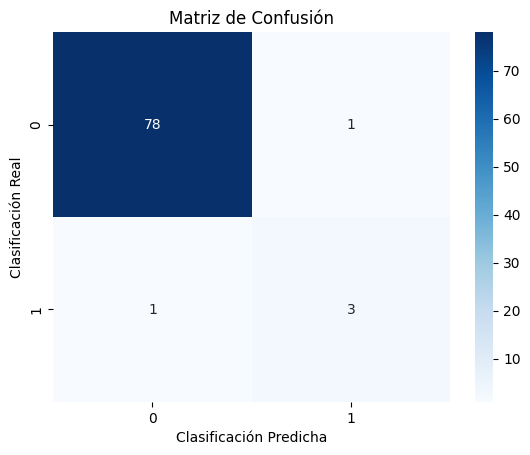

Precisión (Accuracy): 0.9759036144578314


In [38]:

# Suponiendo que tienes las columnas 'Original' y 'Clasificacion' en tu DataFrame 'df'
y_true = predictions['Original']  # Valores reales
y_pred = predictions['Clasificacion']  # Valores predichos

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

# Configurar etiquetas y título
plt.xlabel('Clasificación Predicha')
plt.ylabel('Clasificación Real')
plt.title('Matriz de Confusión')

# Mostrar el mapa de calor
plt.show()

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

print("Precisión (Accuracy):", accuracy)


In [39]:
predictions.to_excel('predictions.xlsx')

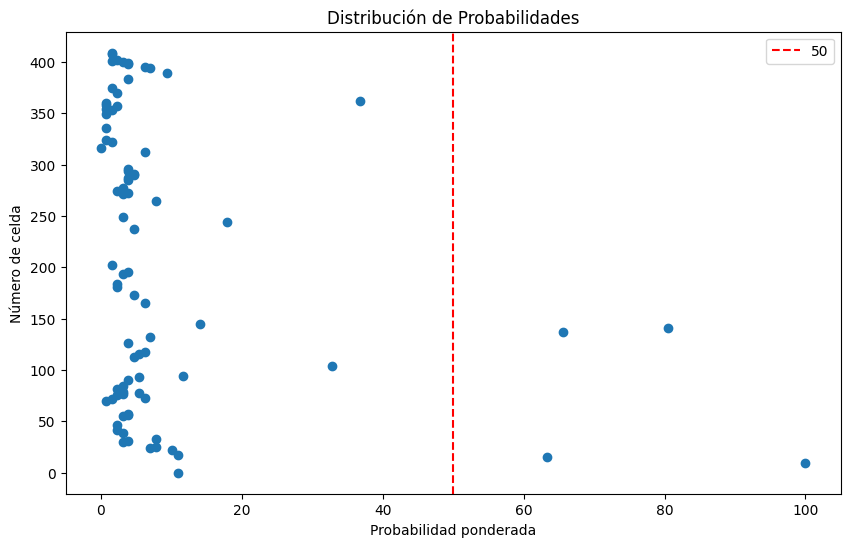

In [40]:
df_sorted = predictions.sort_values(by='Probabilidad ponderada')

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Probabilidad ponderada'], df_sorted.index)

# Trazar una línea vertical en el punto 50 en el eje X
plt.axvline(x=50, color='r', linestyle='--', label='50')

# Añadir etiquetas y leyenda
plt.xlabel('Probabilidad ponderada')
plt.ylabel('Número de celda')
plt.title('Distribución de Probabilidades')
plt.legend()

# Mostrar el gráfico
plt.show()

In [41]:
predictions

,Date,Original,Random Forest,XG Boost,Multiple Linear Regression,Probabilidad ponderada,Clasificacion
0,1990-01-01,0,0.066667,0.020693,0.380133,10.93750,0
9,1990-01-10,1,0.946667,1.283537,0.523282,100.00000,1
15,1991-01-04,0,0.600000,0.832962,0.201985,63.28125,1
17,1991-01-06,0,0.013333,0.099030,0.191426,10.93750,0
22,1991-01-11,0,0.026667,0.084072,0.182948,10.15625,0
...,...,...,...,...,...,...,...
400,2023-01-05,0,0.000000,0.002779,0.000650,3.12500,0
401,2023-01-06,0,0.000000,-0.004953,-0.074398,1.56250,0
402,2023-01-07,0,0.000000,-0.004953,-0.069265,2.34375,0
408,2024-01-01,0,0.000000,-0.004953,-0.120885,1.56250,0


In [42]:
final = combined2.copy()

final['date'] = final['date1']
final = final.drop(['date1','USREC'], axis = 1)
final['Probabilidad ponderada'] = predictions['Probabilidad ponderada']/100

final


,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,Probabilidad ponderada
394,2022-11-01,0.250666,0.017544,0.452670,0.085106,0.982905,0.912447,0.912369,0.070312
349,2019-02-01,0.097069,0.035088,0.285194,0.292553,0.608316,0.697902,0.671649,0.007813
400,2023-05-01,0.142939,0.026316,0.608010,0.098404,0.952316,0.953370,0.946740,0.031250
353,2019-06-01,0.108679,0.017544,0.282767,0.316489,0.625076,0.707898,0.689686,0.015625
181,2005-02-01,0.030072,0.175439,0.297330,0.454787,0.176013,0.356380,0.344996,0.023438
...,...,...,...,...,...,...,...,...,...
287,2013-12-01,0.077274,0.289474,0.004854,0.928191,0.424036,0.570399,0.565970,0.039062
322,2016-11-01,0.097259,0.114035,0.043689,0.555851,0.539619,0.634868,0.610455,0.015625
202,2006-11-01,0.013133,0.096491,0.631068,0.207447,0.208111,0.407872,0.396959,0.015625
274,2012-11-01,0.125048,0.377193,0.013350,0.617021,0.386451,0.546231,0.550820,0.023438


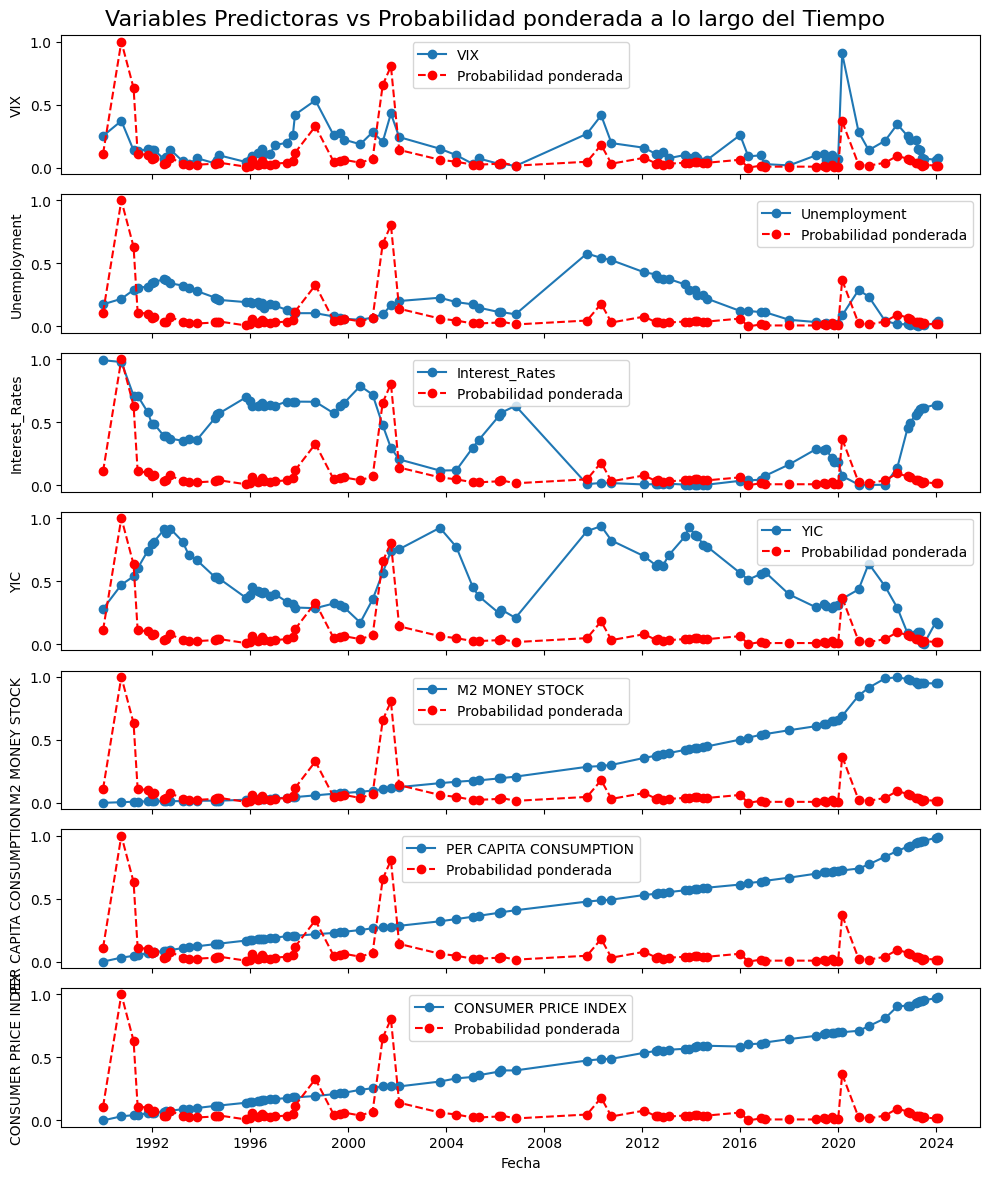

In [43]:
# Asegurarse de que 'date' esté en formato datetime y ordenar por fecha
final['date'] = pd.to_datetime(final['date'], unit='ns')
final = final.sort_values(by='date')

# Obtener las columnas a graficar (excepto 'date', 'Probabilidad ponderada' y 'Clasificacion')
columns_to_plot = [col for col in final.columns if col not in ['date', 'Probabilidad ponderada', 'Clasificacion']]

# Configurar el tamaño de la figura para los subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 12), sharex=True)

# Iterar sobre las columnas y graficar cada una versus 'Probabilidad ponderada'
for i, col in enumerate(columns_to_plot):
    axes[i].plot(final['date'], final[col], marker='o', linestyle='-', label=col)
    axes[i].plot(final['date'], final['Probabilidad ponderada'], linestyle='--', marker='o', color='red', label='Probabilidad ponderada')
    axes[i].set_ylabel(col)
    axes[i].legend()
    
# Configurar etiquetas y título global
fig.suptitle('Variables Predictoras vs Probabilidad ponderada a lo largo del Tiempo', fontsize=16)
plt.xlabel('Fecha')

# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()


In [44]:
count_gt_05 = (final['Probabilidad ponderada'] > 0.5).sum()